In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

### Read in data

In [2]:
adata = sc.read("pbmc3k.h5ad")
adata

AnnData object with n_obs × n_vars = 2638 × 208
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'cell_type'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

#### (A) Perform PCA, t-SNE, and UMAP. And which is more suitable here?

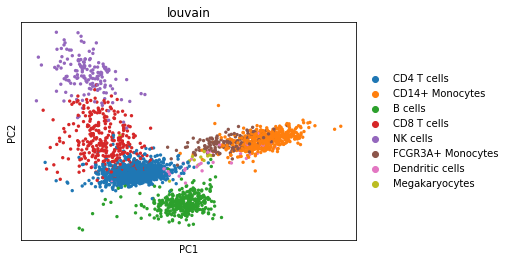

In [3]:
# PCA
#sc.pp.pca(adata, n_comps = 50)
sc.pl.pca(adata, color="louvain")

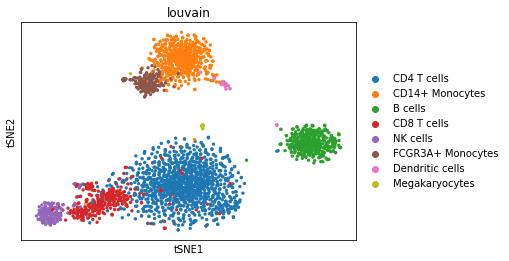

In [5]:
# t-SNE
sc.tl.tsne(adata)
sc.pl.tsne(adata,color=['louvain'])

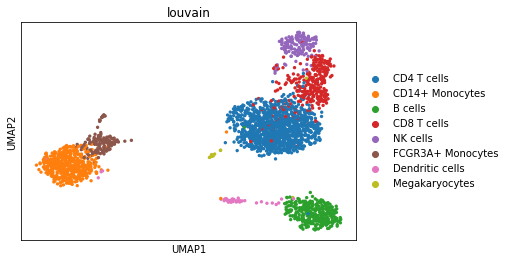

In [7]:
# UMAP
sc.pl.umap(adata,color=['louvain'])

In this dataset, t-SNE and UMAP are doing a obvious better job since the clusters in PCA are not so distinct, some clusters do not have clear boundaries, for example, NK cells (purple) and CD8 T cells (red). As well as FCGR3A+ Monocytes (brown) and CD14+ Monocytes (orange). Further, between t-SNE and UMAP, UMAP result more denser clusters than t-SNE. For example, the CD4 T cells (blue) and CD14+ Monocytes (orange) in t-SNE has more space around the outside area. Actually, by comparing these two methods. UMAP defines more constraints, nearest neighbours and minimum distance, Instead of the single perplexity value in tSNE. nearest neighbours will affect the influence given to global v.s. local information AND Minimum distance will affect how compactly packed the local parts of the plot are. **Overall, UMAP may suit better in this dataset.**

#### (B) Different Perlexity in tSNE

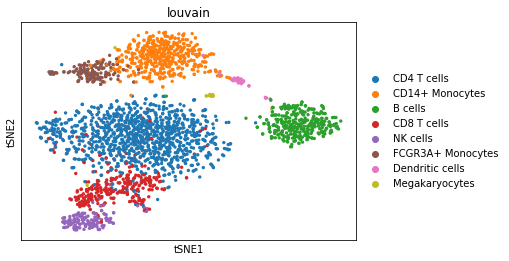

In [12]:
sc.tl.tsne(adata, perplexity = 10)
sc.pl.tsne(adata,color=['louvain'])

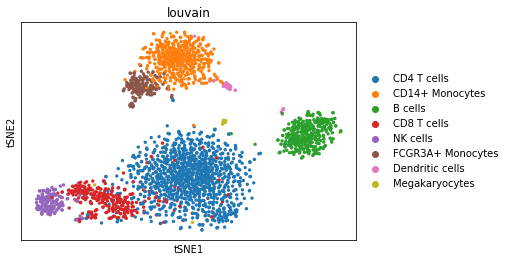

In [13]:
sc.tl.tsne(adata,perplexity = 20)
sc.pl.tsne(adata,color=['louvain'])

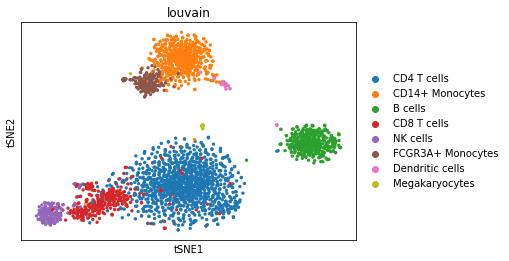

In [14]:
sc.tl.tsne(adata,perplexity = 30)
sc.pl.tsne(adata,color=['louvain'])

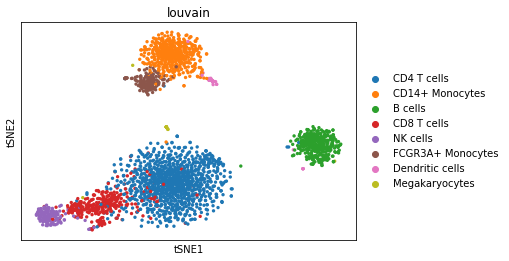

In [15]:
sc.tl.tsne(adata,perplexity = 40)
sc.pl.tsne(adata,color=['louvain'])

The hyper-parametr Perplexity describes the expected number of neighbours within a cluster. It is guessing about the number of close neighbors each data point has, so it could, to some extent, balance attention between local and global aspects. Here I tried 10, 20, 30 and 40. We can see that, with bigger perplexity, the more distinct & denser each cluster is (small perplexity leads to fluffy clusters). But overall, the cluster here the tSNE results are robust to changes in perplexity in this range.

#### (C) Different  n_neighbors and min_dist in UMAP

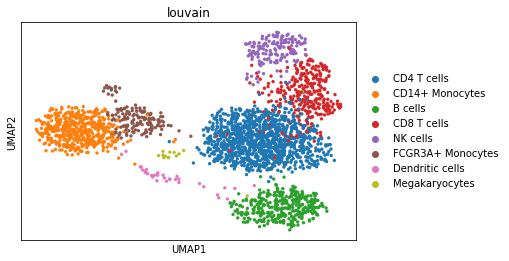

In [16]:
sc.pp.neighbors(adata, n_neighbors = 20)
sc.tl.umap(adata,min_dist = 1)
sc.pl.umap(adata,color=['louvain'])

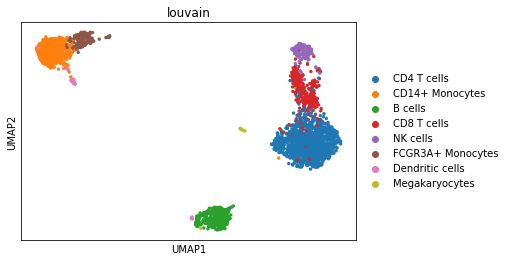

In [17]:
sc.pp.neighbors(adata, n_neighbors = 20)
sc.tl.umap(adata,min_dist = .2)
sc.pl.umap(adata,color=['louvain'])

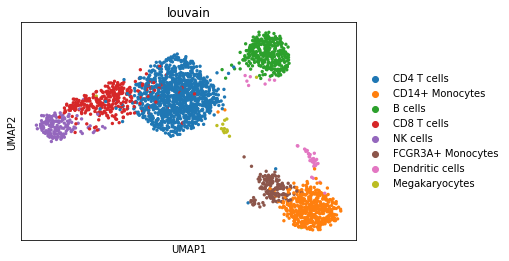

In [18]:
sc.pp.neighbors(adata, n_neighbors = 200)
sc.tl.umap(adata,min_dist = .5)
sc.pl.umap(adata,color=['louvain'])

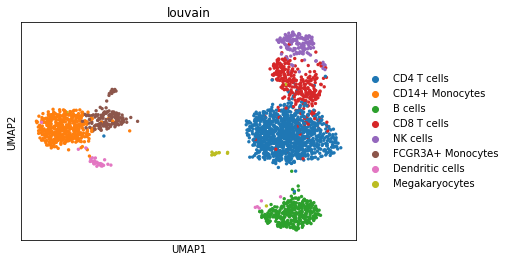

In [19]:
sc.pp.neighbors(adata, n_neighbors = 20)
sc.tl.umap(adata,min_dist = .5)
sc.pl.umap(adata,color=['louvain'])

Here, two comparisons are made:  

(1) Controling n_neighbors = 20, try different min_dist (only showing min_dist = 0.2 and min_dist = 1).  
    
    This controls the minimum distance between points in low-dimensional space - how tightly the points are clumping toghther, the lower the value is, the more tightly they are packed.  
    
(2) Controling min_dist = 0.5, try different n_neighbors (only showing n_neighbors = 20 and n_neighbors = 200).  
    
    This controls the number of approximate nearest neighbors used to construct the initial high-dimensional graph. It can balance the local v.s. global structure. The smaller the value, the more local structure will be shown, otherwise focus more on the big-picture structure. 

#### (D) Identify the cell type marker genes

1. Using wilcoxon

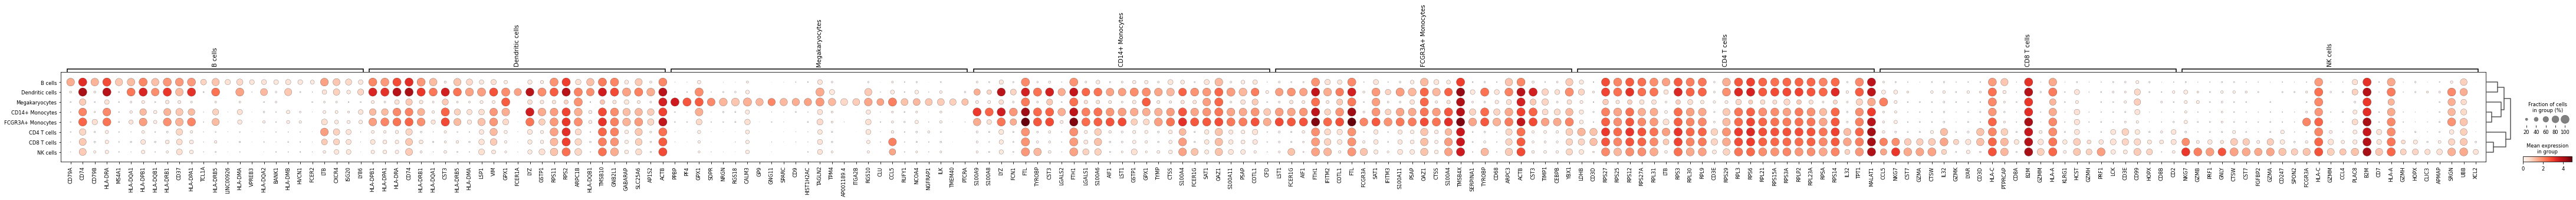

In [22]:
sc.tl.rank_genes_groups(adata,'louvain', method = 'wilcoxon',n_genes = 25)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=25, groupby="cell_type")

# container
matrix_w = []
# all genes
genes_w = adata.uns['rank_genes_groups']['names']
#
for i in range(8):
    tmp_list = []
    matrix_w.append(tmp_list)
    for j in range(25):
        tmp_gene = genes_w[j][i]
        matrix_w[i].append(tmp_gene)       

2. Using t-test

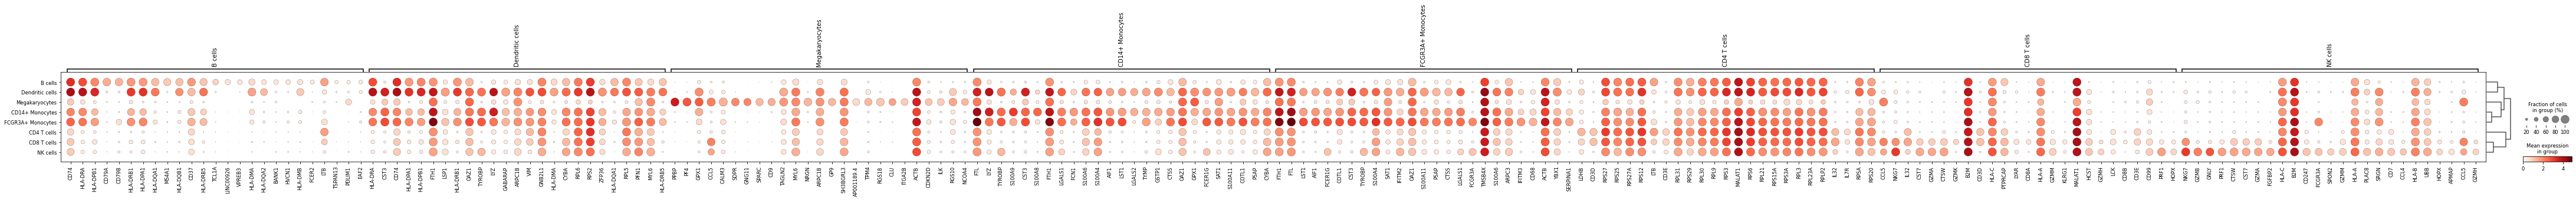

In [25]:
sc.tl.rank_genes_groups(adata,'louvain', method = 't-test', key_added='t-test',n_genes = 25)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=25, key = "t-test", groupby="cell_type")
#
matrix_t = []
# all genes
genes_t = adata.uns['rank_genes_groups']['names']
#adata.uns['rank_genes_groups']['scores']
for i in range(8):
    tmp_list = []
    matrix_t.append(tmp_list)
    for j in range(25):
        tmp_gene = genes_t[j][i]
        matrix_t[i].append(tmp_gene)

In [26]:
#
def ov(lst1, lst2):lst3 = [value for value in lst1 if value in lst2]; return len(lst3)
# all cell types
all_cell_types = ['CD4_T_cells','CD14_Monocytes','B_cells','CD8_T_cells','NK_cells','FCGR3A_Monocytes','Dendritic_cells','Megakaryocytes']

## find overlap
print('DEGs overlap between wilcoxon and t-test:\n')
for i in range(8): 
    print('In {0}, - {1} overlapping DEGs.\n'.format(all_cell_types[i],ov(matrix_w[i],matrix_t[i])))

DEGs overlap between wilcoxon and t-test:

In CD4_T_cells, - 23 overlapping DEGs.

In CD14_Monocytes, - 24 overlapping DEGs.

In B_cells, - 22 overlapping DEGs.

In CD8_T_cells, - 24 overlapping DEGs.

In NK_cells, - 23 overlapping DEGs.

In FCGR3A_Monocytes, - 23 overlapping DEGs.

In Dendritic_cells, - 16 overlapping DEGs.

In Megakaryocytes, - 20 overlapping DEGs.



Differentially expressed genes (cell type marker genes) identified in each of the 8 cell types, with 25 plotted in the figure. Overall, two methods identified a large number of overlapping genes. See the number of overlapping genes below. Since these two methods identified pretty much the same sets of genes (althrough with slightly different rankings), the results indicates that - B cells, Megakaryocytes and NK_cells has their only unique set of "marker genes", which means those genes are significant only in the corresponding cells. However, CD4 T cells, has a ver common set of marker genes, these genes are also significant in other type of cells.